In [1]:
import datetime
from datetime import date
from datetime import datetime
import requests
import pprint
from bs4 import BeautifulSoup
import pandas as pd
import re
import pickle
from urllib.request import urlopen
import glob
# import altair as alt
import time
import itertools
import numpy as np
import operator
from datetime import timedelta
from ipywidgets import interact, IntSlider
from IPython.display import display

pd.options.display.max_columns = 5000
pd.options.display.max_rows = 5000

In [3]:
# Load Dataset

# Renzo's Path
dataset = pd.read_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1KUGn_35OjAoOP2puz6yG-2g_8LBxvDG_/SIADS 697 - Capstone/Dataframes/complete_final_df_5.csv')

# Sravan's Path
# dataset = pd.read_csv('/Users/srav88/My Drive/SIADS 697 - Capstone/Dataframes/complete_final_df_3.csv')

KeyboardInterrupt: 

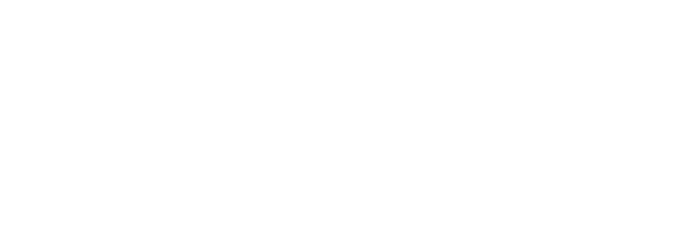

In [7]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

fig, ax =plt.subplots(figsize=(12,4))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=dataset.values,colLabels=dataset.columns,loc='center')

pp = PdfPages("foo.pdf")
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [351]:
# Dropping zero lines
dataset = dataset[dataset['FBRefID'] != 0]

In [352]:
# Filling in some missing values

def clean_columns(df, column):
    df.loc[dataset[column].isnull(), column] = 0
    return df

columns_to_clean = ['Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Press', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 'SCA', 'GCA', 'Prog', 'Carries', 'Prog.1', 'Succ', 'Att.1', 
                    'Fls', 'Off', 'Crs', 'TklW', 'OG', 'PKwon', 'PKcon', 'Won', 'Loss', 'Draw'] 

# all have 150755 NaN's, of which none are when matches are played, so we equal those \
# NaN's in these variables to 0

for i in columns_to_clean:
    dataset = clean_columns(dataset, i)

# dataset.loc[dataset['Min'].isnull(), 'Min'] = 0
# dataset.loc[dataset['Gls'].isnull(), 'Gls'] = 0
# dataset.loc[dataset['Ast'].isnull(), 'Ast'] = 0
# dataset.loc[dataset['PK'].isnull(), 'PK'] = 0
# dataset.loc[dataset['PKatt'].isnull(), 'PKatt'] = 0
# dataset.loc[dataset['Sh'].isnull(), 'Sh'] = 0
# dataset.loc[dataset['SoT'].isnull(), 'SoT'] = 0
# dataset.loc[dataset['CrdY'].isnull(), 'CrdY'] = 0
# dataset.loc[dataset['CrdR'].isnull(), 'CrdR'] = 0
# dataset.loc[dataset['Touches'].isnull(), 'Touches'] = 0
# dataset.loc[dataset['Press'].isnull(), 'Press'] = 0
# dataset.loc[dataset['Tkl'].isnull(), 'Tkl'] = 0
# dataset.loc[dataset['Int'].isnull(), 'Int'] = 0
# dataset.loc[dataset['Blocks'].isnull(), 'Blocks'] = 0
# dataset.loc[dataset['xG'].isnull(), 'xG'] = 0
# dataset.loc[dataset['npxG'].isnull(), 'npxG'] = 0
# dataset.loc[dataset['xA'].isnull(), 'xA'] = 0
# dataset.loc[dataset['SCA'].isnull(), 'SCA'] = 0
# dataset.loc[dataset['GCA'].isnull(), 'GCA'] = 0
# dataset.loc[dataset['Prog'].isnull(), 'Prog'] = 0
# dataset.loc[dataset['Carries'].isnull(), 'Carries'] = 0
# dataset.loc[dataset['Prog.1'].isnull(), 'Prog.1'] = 0
# dataset.loc[dataset['Succ'].isnull(), 'Succ'] = 0
# dataset.loc[dataset['Att.1'].isnull(), 'Att.1'] = 0
# dataset.loc[dataset['Fls'].isnull(), 'Fls'] = 0
# dataset.loc[dataset['Off'].isnull(), 'Off'] = 0
# dataset.loc[dataset['Crs'].isnull(), 'Crs'] = 0
# dataset.loc[dataset['TklW'].isnull(), 'TklW'] = 0
# dataset.loc[dataset['OG'].isnull(), 'OG'] = 0
# dataset.loc[dataset['PKwon'].isnull(), 'PKwon'] = 0
# dataset.loc[dataset['PKcon'].isnull(), 'PKcon'] = 0
# dataset.loc[dataset['Won'].isnull(), 'Won'] = 0
# dataset.loc[dataset['Loss'].isnull(), 'Loss'] = 0
# dataset.loc[dataset['Draw'].isnull(), 'Draw'] = 0

In [353]:
# Assigning Dummy Variables for player position from 'Position:'
dataset.loc[dataset['Position:'].isnull(), 'Position:'] = ''

dataset['defender'] = np.where(dataset['Position:'].str.contains('Defender'), 1, 0)
dataset['attacker'] = np.where(dataset['Position:'].str.contains('attack'), 1, 0)
dataset['midfielder'] = np.where(dataset['Position:'].str.contains('midfield'), 1, 0)
dataset['goalkeeper'] = np.where(dataset['Position:'].str.contains('Goalkeeper'), 1, 0)

In [354]:
# Creating the Column Age from current_date and birth and cleaning unneeded features

dates = (dataset['agg_year'] * 100 + dataset['agg_week']).astype(int)

dataset['date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')

dataset['age'] = round((pd.to_datetime(dataset['date']) - pd.to_datetime(dataset['Birth'])) / timedelta(days=365), 0)

dataset['retired'] = np.where(dataset['Retired since:'].isnull(), 0, 1)

dataset.drop(columns = ['Retired since:', 'Position:', 'PlayerName', 'FootAbility', 'Ban since:', 'current_year', 'current_week', 'FBRefId', 'date', 'Birth'], inplace = True)


# dataset[dataset['FBRefID'] == '71672fa0'].tail(10)

In [355]:
# Sorting values in dataset_for_model
dataset = dataset.sort_values(['FBRefID', 'agg_year', 'agg_week'])

In [356]:
# Creating 'injured' column

dataset.loc[dataset['Injury'] != '0', 'injured'] = 1
dataset.loc[dataset['Injury'] == '0', 'injured'] = 0

# dataset[dataset['FBRefID'] == '71672fa0'].tail(60)

In [357]:
# Creating target column 'injured_in_one_week' and creating cumulative features
def shift_by_time_period(df, shift_factor, column):
    df[column + '_in_' + str(shift_factor) + '_week'] = df.groupby('FBRefID')[column].shift(shift_factor*-1)
    return df


dataset = shift_by_time_period(dataset, 1, 'injured')
dataset = shift_by_time_period(dataset, 4, 'injured')
dataset = shift_by_time_period(dataset, 12, 'injured')
dataset = shift_by_time_period(dataset, 26, 'injured')
dataset = shift_by_time_period(dataset, 52, 'injured')

# dataset['injured_in_one_week'] = dataset.groupby('FBRefID').injured.shift(-1)
# dataset[dataset['injured_in_one_week'].isna()] = 0

dataset[dataset['FBRefID'] == 'dea698d9'].tail(60)

,name,FBRefID,agg_week,agg_year,Injury,injury_week,injury_year,TMID,Min,Gls,Ast,PK,PKatt,Sh,SoT,CrdY,CrdR,Touches,Press,Tkl,Int,Blocks,xG,npxG,xA,SCA,GCA,Cmp,Att,Prog,Carries,Prog.1,Succ,Att.1,Fls,Fld,Off,Crs,TklW,OG,PKwon,PKcon,Won,Loss,Draw,release_week,was_match,Height,Weight,Foot,defender,attacker,midfielder,goalkeeper,age,retired,injured,injured_in_1_week,injured_in_4_week,injured_in_12_week,injured_in_26_week,injured_in_52_week
1011808,Cristiano-Ronaldo,dea698d9,28.0,2020.0,0,0.0,0.0,0,180.0,3.0,0.0,2.0,2.0,5.0,2.0,0.0,0.0,98.0,9.0,1.0,1.0,0.0,2.4,0.8,0.1,4.0,1.0,63.0,75.0,4.0,72.0,14.0,4.0,6.0,1.0,6.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,187.0,83.0,RIGHT,0,0,0,0,35.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1011809,Cristiano-Ronaldo,dea698d9,29.0,2020.0,0,0.0,0.0,0,90.0,0.0,0.0,0.0,0.0,10.0,2.0,1.0,0.0,53.0,5.0,2.0,0.0,0.0,1.0,1.0,0.0,7.0,0.0,36.0,36.0,2.0,33.0,9.0,2.0,3.0,3.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,187.0,83.0,RIGHT,0,0,0,0,35.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1011810,Cristiano-Ronaldo,dea698d9,30.0,2020.0,0,0.0,0.0,0,270.0,3.0,0.0,1.0,2.0,22.0,7.0,0.0,0.0,160.0,21.0,2.0,0.0,1.0,3.9,2.4,0.6,13.0,2.0,97.0,116.0,8.0,117.0,32.0,0.0,3.0,2.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,3.0,187.0,83.0,RIGHT,0,0,0,0,36.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1011811,Cristiano-Ronaldo,dea698d9,31.0,2020.0,0,0.0,0.0,0,90.0,0.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0,60.0,2.0,0.0,0.0,0.0,0.4,0.4,0.1,9.0,0.0,35.0,42.0,2.0,57.0,13.0,4.0,5.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,187.0,83.0,RIGHT,0,0,0,0,36.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1011812,Cristiano-Ronaldo,dea698d9,32.0,2020.0,0,0.0,0.0,0,90.0,2.0,0.0,1.0,1.0,8.0,2.0,0.0,0.0,45.0,10.0,0.0,0.0,0.0,1.2,0.4,0.2,5.0,0.0,28.0,33.0,3.0,23.0,8.0,0.0,0.0,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,187.0,83.0,RIGHT,0,0,0,0,36.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1011813,Cristiano-Ronaldo,dea698d9,37.0,2020.0,0,0.0,0.0,0,160.0,4.0,0.0,0.0,0.0,14.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,187.0,83.0,RIGHT,0,0,0,0,36.0,1,0.0,0.0,1.0,0.0,0.0,0.0
1011814,Cristiano-Ronaldo,dea698d9,38.0,2020.0,0,0.0,0.0,0,180.0,2.0,0.0,0.0,0.0,20.0,6.0,0.0,0.0,51.0,6.0,0.0,0.0,0.0,1.2,1.2,0.0,4.0,0.0,29.0,33.0,3.0,33.0,11.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,187.0,83.0,RIGHT,0,0,0,0,36.0,1,0.0,0.0,1.0,0.0,0.0,0.0
1011815,Cristiano-Ronaldo,dea698d9,39.0,2020.0,0,0.0,0.0,0,180.0,4.0,0.0,2.0,2.0,6.0,4.0,0.0,0.0,43.0,13.0,0.0,0.0,2.0,1.2,0.4,0.0,2.0,1.0,23.0,32.0,2.0,28.0,10.0,1.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,187.0,83.0,RIGHT,0,0,0,0,36.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1011816,Cristiano-Ronaldo,dea698d9,41.0,2020.0,0,0.0,0.0,0,324.0,0.0,0.0,0.0,0.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,187.0,83.0,RIGHT,0,0,0,0,36.0,1,0.0,1.0,0.0,0.0,1.0,NaN
1011817,0,dea698d9,42.0,2020.0,Corona virus,42.0,2020.0,8198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,187.0,83.0,RIGHT,0,1,0,0,36.0,1,1.0,1.0,0.0,0.0,0.0,NaN


In [358]:
# Dropping zero lines

dataset = dataset[dataset['FBRefID'] != 0]

In [341]:
# #   reset  val  desired_col
# #0      0    1            1
# #1      0    5            6
# #2      0    4           10
# #3      1    2            2
# #4      1   -1           -1
# #5      0    6            5
# #6      0    4            9
# #7      1    2            2
# df['cumsum'] = df['reset'].cumsum()
# #cumulative sums of groups to column des
# df['des']= df.groupby(['cumsum'])['val'].cumsum()
# print df
# #   reset  val  desired_col  cumsum  des
# #0      0    1            1       0    1
# #1      0    5            6       0    6
# #2      0    4           10       0   10
# #3      1    2            2       1    2
# #4      1   -1           -1       2   -1
# #5      0    6            5       2    5
# #6      0    4            9       2    9
# #7      1    2            2       3    2
# #remove columns desired_col and cumsum
# df = df.drop(['desired_col', 'cumsum'], axis=1)
# print df
# #   reset  val  des
# #0      0    1    1
# #1      0    5    6
# #2      0    4   10
# #3      1    2    2
# #4      1   -1   -1
# #5      0    6    5
# #6      0    4    9
# #7      1    2    2

In [359]:
# Creating 'cum_sum' column to serve as base for cummulative features

dataset['cum_sum'] = dataset['injured'].cumsum()

# dataset['Min_cum'] = dataset.groupby(['FBRefID', 'cum_sum'])['Min'].cumsum()


In [360]:
# Creating function to add cummulative columns

def cummulative_sum(dataset, cum_column, original_column):
    dataset[cum_column] = dataset.groupby(['FBRefID', 'cum_sum'])[original_column].cumsum()
    return dataset

In [361]:
# Creating cummulative variables
cum_cols = ['Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY', 'CrdR', 'Touches', 'Press', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xA', 
    'SCA', 'GCA', 'Cmp', 'Att', 'Prog', 'Carries', 'Prog.1', 'Succ', 'Att.1', 'Fls', 'Fld', 'Off', 'Crs', 'TklW', 'OG', 'PKwon', 'PKcon', 'Won', 
    'Loss', 'Draw', 'was_match']

for var in cum_cols:
    cummulative_sum(dataset, var+'_cum', var)



In [367]:
dataset[dataset['FBRefID'] == 'dea698d9'][['agg_week', 'agg_year', 'Sh', 'Sh_cum', 'was_match']]

,agg_week,agg_year,Sh,Sh_cum,was_match
1011105,33.0,2002.0,0.0,0.0,1.0
1011106,37.0,2002.0,0.0,0.0,1.0
1011107,38.0,2002.0,0.0,0.0,1.0
1011108,39.0,2002.0,0.0,0.0,2.0
1011109,40.0,2002.0,0.0,0.0,1.0
1011110,41.0,2002.0,0.0,0.0,1.0
1011111,42.0,2002.0,0.0,0.0,1.0
1011112,43.0,2002.0,0.0,0.0,1.0
1011113,44.0,2002.0,0.0,0.0,1.0
1011114,45.0,2002.0,0.0,0.0,1.0


In [346]:
dataset.head()

,name,FBRefID,agg_week,agg_year,Injury,injury_week,injury_year,TMID,Min,Gls,Ast,PK,PKatt,Sh,SoT,CrdY,CrdR,Touches,Press,Tkl,Int,Blocks,xG,npxG,xA,SCA,GCA,Cmp,Att,Prog,Carries,Prog.1,Succ,Att.1,Fls,Fld,Off,Crs,TklW,OG,PKwon,PKcon,Won,Loss,Draw,release_week,was_match,Height,Weight,Foot,defender,attacker,midfielder,goalkeeper,age,retired,injured,injured_in_one_week,cum_sum,Min_cum,Gls_cum,Ast_cum,PK_cum,PKatt_cum,Sh_cum,SoT_cum,CrdY_cum,CrdR_cum,Touches_cum,Press_cum,Tkl_cum,Int_cum,Blocks_cum,xG_cum,npxG_cum,xA_cum,SCA_cum,GCA_cum,Cmp_cum,Att_cum,Prog_cum,Carries_cum,Prog.1_cum,Succ_cum,Att.1_cum,Fls_cum,Fld_cum,Off_cum,Crs_cum,TklW_cum,OG_cum,PKwon_cum,PKcon_cum,Won_cum,Loss_cum,Draw_cum,was_match_cum
0,0,0000acda,46.0,2013.0,Calf Problems,46.0,2013.0,201040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,184.0,80.0,RIGHT,0,0,1,0,19.0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0000acda,45.0,2014.0,Unknown Injury,45.0,2014.0,201040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,184.0,80.0,RIGHT,0,0,1,0,20.0,1,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0000acda,46.0,2014.0,Unknown Injury,45.0,2014.0,201040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,184.0,80.0,RIGHT,0,0,1,0,20.0,1,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0000acda,47.0,2014.0,Unknown Injury,45.0,2014.0,201040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,0.0,184.0,80.0,RIGHT,0,0,1,0,20.0,1,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0000acda,49.0,2014.0,Thigh Problems,49.0,2014.0,201040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,184.0,80.0,RIGHT,0,0,1,0,20.0,1,1.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [347]:
# Saving dataset_for_model_final to Google Drive

# Renzo's path
dataset.to_csv('/Volumes/GoogleDrive/.shortcut-targets-by-id/1KUGn_35OjAoOP2puz6yG-2g_8LBxvDG_/SIADS 697 - Capstone/Dataframes/dataset_for_model_final.csv', index=False)